# VGAE Implementation

```
@article{kipf2016variational,
  title={Variational Graph Auto-Encoders},
  author={Kipf, Thomas N and Welling, Max},
  journal={NIPS Workshop on Bayesian Deep Learning},
  year={2016}
}
```

## Import Library

In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.startup_data_set import COMP4222Dataset_hetero
from utils.PredictorClasses import *
from utils.CustomMetrics import *
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
device = torch.device('cpu')
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Hypermeters

In [2]:
val_ratio = 0.1
test_ratio = 0.1

# Hyperparameters
n_hidden = 32
output_dim = 16

lr=0.05
early_stopping = 5
ep = 150

## Load Dataset / Graph Preparation

In [3]:
graph = COMP4222Dataset_hetero()[0]
graph = dgl.to_homogeneous(graph,ndata=['feat'],edata=['feat'])
graph

7594


Graph(num_nodes=25446, num_edges=45621,
      ndata_schemes={'feat': Scheme(shape=(221,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(23,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})

In [4]:
in_feats = graph.ndata['feat'].shape[1]
in_feats

221

In [5]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn.functional as F
from sklearn.metrics import average_precision_score, roc_auc_score

In [6]:
def compute_loss_para(adj):
    pos_weight = (adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
    norm = (
        adj.shape[0]
        * adj.shape[0]
        / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
    )
    weight_mask = adj.view(-1) == 1
    weight_tensor = torch.ones(weight_mask.size(0)).to(device)
    weight_tensor[weight_mask] = pos_weight
    return weight_tensor, norm


def get_acc(adj_rec, adj_label):
    labels_all = adj_label.view(-1).long()
    preds_all = (adj_rec > 0.5).view(-1).long()
    accuracy = (preds_all == labels_all).sum().float() / labels_all.size(0)
    return accuracy


def get_scores(edges_pos, edges_neg, adj_rec):
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    adj_rec = adj_rec.cpu()
    # Predict on test set of edges
    preds = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]].item()))

    preds_neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]].data))

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

def mask_test_edges_dgl(graph, adj):
    src, dst = graph.edges()
    edges_all = torch.stack([src, dst], dim=0)
    edges_all = edges_all.t().cpu().numpy()
    num_test = int(np.floor(edges_all.shape[0] / 10.0))
    num_val = int(np.floor(edges_all.shape[0] / 20.0))

    all_edge_idx = list(range(edges_all.shape[0]))
    np.random.shuffle(all_edge_idx)
    val_edge_idx = all_edge_idx[:num_val]
    test_edge_idx = all_edge_idx[num_val : (num_val + num_test)]
    train_edge_idx = all_edge_idx[(num_val + num_test) :]
    test_edges = edges_all[test_edge_idx]
    val_edges = edges_all[val_edge_idx]
    train_edges = np.delete(
        edges_all, np.hstack([test_edge_idx, val_edge_idx]), axis=0
    )

    def ismember(a, b, tol=5):
        rows_close = np.all(np.round(a - b[:, None], tol) == 0, axis=-1)
        return np.any(rows_close)

    test_edges_false = []
    while len(test_edges_false) < len(test_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue
        if ismember([idx_i, idx_j], edges_all):
            continue
        if test_edges_false:
            if ismember([idx_j, idx_i], np.array(test_edges_false)):
                continue
            if ismember([idx_i, idx_j], np.array(test_edges_false)):
                continue
        test_edges_false.append([idx_i, idx_j])

    val_edges_false = []
    while len(val_edges_false) < len(val_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue
        if ismember([idx_i, idx_j], train_edges):
            continue
        if ismember([idx_j, idx_i], train_edges):
            continue
        if ismember([idx_i, idx_j], val_edges):
            continue
        if ismember([idx_j, idx_i], val_edges):
            continue
        if val_edges_false:
            if ismember([idx_j, idx_i], np.array(val_edges_false)):
                continue
            if ismember([idx_i, idx_j], np.array(val_edges_false)):
                continue
        val_edges_false.append([idx_i, idx_j])

    assert ~ismember(test_edges_false, edges_all)
    assert ~ismember(val_edges_false, edges_all)
    assert ~ismember(val_edges, train_edges)
    assert ~ismember(test_edges, train_edges)
    assert ~ismember(val_edges, test_edges)

    # NOTE: these edge lists only contain single direction of edge!
    return (
        train_edge_idx,
        val_edges,
        val_edges_false,
        test_edges,
        test_edges_false,
    )


## Model Training

### Model Setup

In [7]:
from dgl.nn.pytorch import GraphConv


class VGAEModel(nn.Module):
    def __init__(self, in_dim, hidden1_dim, hidden2_dim):
        super(VGAEModel, self).__init__()
        self.in_dim = in_dim
        self.hidden1_dim = hidden1_dim
        self.hidden2_dim = hidden2_dim

        layers = [
            GraphConv(
                self.in_dim,
                self.hidden1_dim,
                activation=F.relu,
                allow_zero_in_degree=True,
            ),
            GraphConv(
                self.hidden1_dim,
                self.hidden2_dim,
                activation=lambda x: x,
                allow_zero_in_degree=True,
            ),
            GraphConv(
                self.hidden1_dim,
                self.hidden2_dim,
                activation=lambda x: x,
                allow_zero_in_degree=True,
            ),
        ]
        self.layers = nn.ModuleList(layers)

    def encoder(self, g, features):
        h = self.layers[0](g, features)
        self.mean = self.layers[1](g, h)
        self.log_std = self.layers[2](g, h)
        gaussian_noise = torch.randn(features.size(0), self.hidden2_dim).to(
            device
        )
        sampled_z = self.mean + gaussian_noise * torch.exp(self.log_std).to(
            device
        )
        return sampled_z

    def decoder(self, z):
        adj_rec = torch.sigmoid(torch.matmul(z, z.t()))
        return adj_rec

    def forward(self, g, features):
        z = self.encoder(g, features)
        adj_rec = self.decoder(z)
        return adj_rec

In [8]:
# Extract node features
feats = graph.ndata.pop("feat").to(device)
in_dim = feats.shape[-1]

# generate input
adj_orig = graph.adjacency_matrix().to_dense()

# build test set with 10% positive links
(
    train_edge_idx,
    val_edges,
    val_edges_false,
    test_edges,
    test_edges_false,
) = mask_test_edges_dgl(graph, adj_orig)

graph = graph.to(device)

# create train graph
train_edge_idx = torch.tensor(train_edge_idx).to(device)
train_graph = dgl.edge_subgraph(graph, train_edge_idx, relabel_nodes=False)
train_graph = train_graph.to(device)
adj = train_graph.adjacency_matrix().to_dense().to(device)

# compute loss parameters
weight_tensor, norm = compute_loss_para(adj)

# create model
vgae_model = VGAEModel(
    in_feats,
    n_hidden,
    output_dim
)
vgae_model = vgae_model.to(device)

# create training component
optimizer = torch.optim.Adam(vgae_model.parameters(), lr=lr)
print(
    "Total Parameters:",
    sum([p.nelement() for p in vgae_model.parameters()]),
)

Total Parameters: 8160


### Training Loop

In [9]:
feats

tensor([[0.5803, 0.4444, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1096, 0.0748, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0038, 0.0023, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0667, 0.3333, 0.0160,  ..., 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.0126,  ..., 0.0000, 0.0000, 0.0000],
        [0.1333, 0.1111, 0.0017,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)

In [10]:
train_loss = []
val_AUC = []

for epoch in range(ep):
    # Training and validation using a full graph
    vgae_model.train()

    logits = vgae_model.forward(graph, feats.float())

    # compute loss
    loss = norm * F.binary_cross_entropy(
        logits.view(-1), adj.view(-1), weight=weight_tensor
    )
    kl_divergence = (
        0.5
        / logits.size(0)
        * (
            1
            + 2 * vgae_model.log_std
            - vgae_model.mean**2
            - torch.exp(vgae_model.log_std) ** 2
        )
        .sum(1)
        .mean()
    )
    loss -= kl_divergence

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_acc = get_acc(logits, adj)

    val_roc, val_ap = get_scores(val_edges, val_edges_false, logits)

    # Print out performance
    print(
        "Epoch:",
        "%04d" % (epoch + 1),
        "train_loss=",
        "{:.5f}".format(loss.item()),
        "train_acc=",
        "{:.5f}".format(train_acc),
        "val_roc=",
        "{:.5f}".format(val_roc),
        "val_ap=",
        "{:.5f}".format(val_ap)
    )

    train_loss.append(loss.item())
    val_AUC.append(val_roc)


Epoch: 0001 train_loss= 1.72691 train_acc= 0.50003 val_roc= 0.48655 val_ap= 0.48720
Epoch: 0002 train_loss= 1.58710 train_acc= 0.49574 val_roc= 0.49936 val_ap= 0.49730
Epoch: 0003 train_loss= 1.47138 train_acc= 0.49453 val_roc= 0.50926 val_ap= 0.51219
Epoch: 0004 train_loss= 1.37517 train_acc= 0.49570 val_roc= 0.49696 val_ap= 0.49620
Epoch: 0005 train_loss= 1.28266 train_acc= 0.49690 val_roc= 0.49818 val_ap= 0.50171
Epoch: 0006 train_loss= 1.20516 train_acc= 0.49614 val_roc= 0.50062 val_ap= 0.50386
Epoch: 0007 train_loss= 1.13125 train_acc= 0.49394 val_roc= 0.50661 val_ap= 0.51003
Epoch: 0008 train_loss= 1.07177 train_acc= 0.49298 val_roc= 0.49851 val_ap= 0.49351
Epoch: 0009 train_loss= 1.01942 train_acc= 0.49184 val_roc= 0.50717 val_ap= 0.51303
Epoch: 0010 train_loss= 0.97529 train_acc= 0.49351 val_roc= 0.50147 val_ap= 0.49639
Epoch: 0011 train_loss= 0.93827 train_acc= 0.49466 val_roc= 0.49459 val_ap= 0.49517
Epoch: 0012 train_loss= 0.90350 train_acc= 0.49636 val_roc= 0.49470 val_ap= 

KeyboardInterrupt: 

In [11]:

test_roc, test_ap = get_scores(test_edges, test_edges_false, logits)
# roc_means.append(test_roc)
# ap_means.append(test_ap)
print(
    "End of training!",
    "test_roc=",
    "{:.5f}".format(test_roc),
    "test_ap=",
    "{:.5f}".format(test_ap),
)

End of training! test_roc= 0.49896 test_ap= 0.49349


### Result Plotting

Text(0, 0.5, 'Loss')

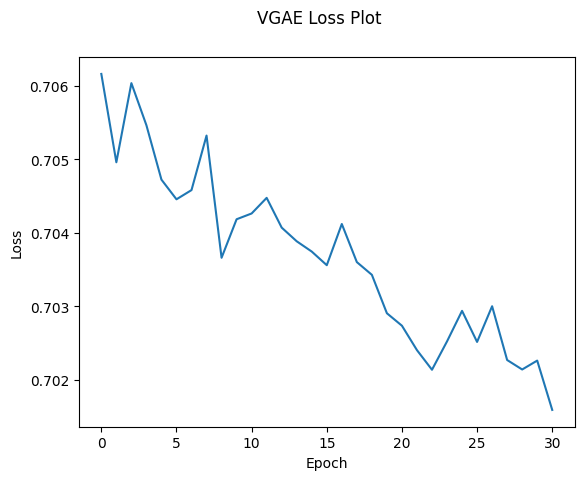

In [12]:
fig = plt.figure()
plt.plot(train_loss[60:], label='training loss')
fig.suptitle('VGAE Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'AUC')

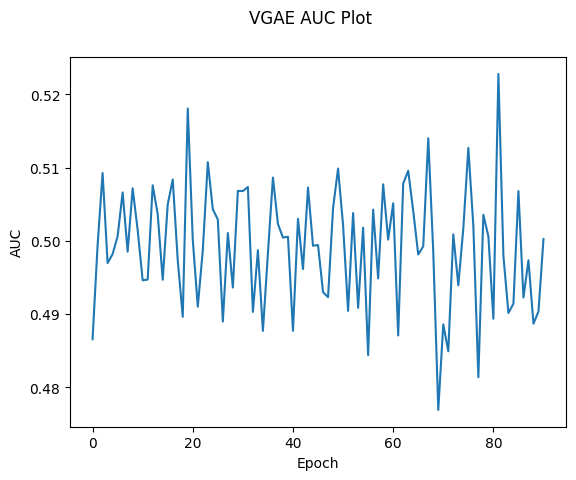

In [13]:
fig = plt.figure()
#plt.plot(train_AUC, label='training AUC')
plt.plot(val_AUC, label = 'validation AUC')
fig.suptitle('VGAE AUC Plot')
plt.xlabel('Epoch')
plt.ylabel('AUC')